In [1]:
import numpy as np
import pandas as pd
import torch
import pickle
import matplotlib.pyplot as plt
from lpne.models import DcsfaNmf

MODEL_FILE = "/hpc/home/mk423/Anxiety/FullDataWork/Models/Final_mt_Model_500_epochs.pt"
DATA_PATH = "/work/mk423/Anxiety/"
PROJECT_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
FIGURE_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Figures/"
#data_file = DATA_PATH + "EPM_test_dict_May_17.pkl"
proj_file = PROJECT_PATH + "EPM_TrainVal_Projections.csv"
#mean_file = PROJECT_PATH + "EPM_Holdout_mean_scores.csv"

model = torch.load(MODEL_FILE,map_location="cpu")
model.device="cpu"


old_feature_list = ["X_power_1_2","X_coh_1_2","X_gc_1_2"]
feature_weights = [10,1,1]



import os, sys
umc_data_tools_path = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
sys.path.append(umc_data_tools_path)
import umc_data_tools as umc_dt

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/hpc/home/mk423/.local/lib/python3.7/site-packages/lpne/pipelines/__init__.py:14: UserWarning: Could not load lpne/pipelines/default_params.yaml!
  warnings.warn("Could not load lpne/pipelines/default_params.yaml!")


In [2]:
df_full = pd.read_csv(proj_file)
df_in_task = df_full[df_full['in-task']==1].copy()

### Closed -> Open vs. Open -> Closed Transitions

Mouse04193
Mouse04201
Mouse04202
Mouse04205
Mouse04215
Mouse0630
Mouse0633
Mouse0634
Mouse0642
Mouse0643
Mouse1551
Mouse39114
Mouse39124
Mouse39125
Mouse39133
Mouse6291
Mouse6292
Mouse6293
Mouse69064
Mouse69065
Mouse69074
Mouse8580
Mouse8581
Mouse8582
Mouse8891
Mouse8894
['Mouse04193' 'Mouse04201' 'Mouse04202' 'Mouse04215' 'Mouse0630'
 'Mouse0633' 'Mouse0634' 'Mouse0642' 'Mouse0643' 'Mouse1551' 'Mouse39124'
 'Mouse39125' 'Mouse39133' 'Mouse6291' 'Mouse6292' 'Mouse6293'
 'Mouse69064' 'Mouse69065' 'Mouse69074' 'Mouse8580' 'Mouse8581'
 'Mouse8891'] [list([397, 411, 479, 535, 644]) list([357, 366, 460, 526, 595, 647])
 list([369, 455, 575]) list([345])
 list([178, 198, 233, 374, 480, 513, 589, 650, 714])
 list([159, 174, 199, 234, 252, 274, 317, 610, 628, 685])
 list([297, 377, 408, 739])
 list([189, 312, 343, 487, 513, 540, 589, 649, 656, 755])
 list([169, 185, 204, 287])
 list([162, 175, 180, 229, 271, 282, 328, 446, 473, 487, 494, 568, 596])
 list([338, 414, 433, 612, 631, 636]) list([4

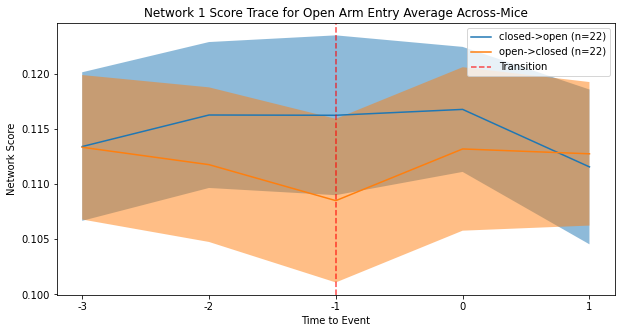

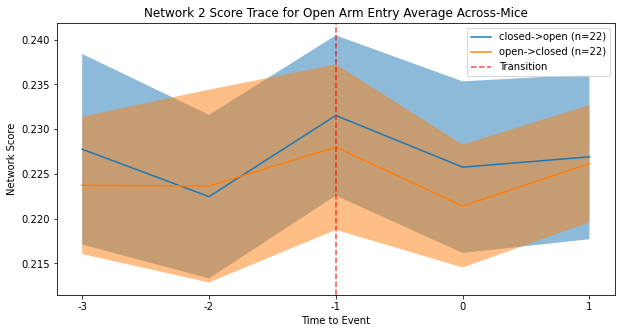

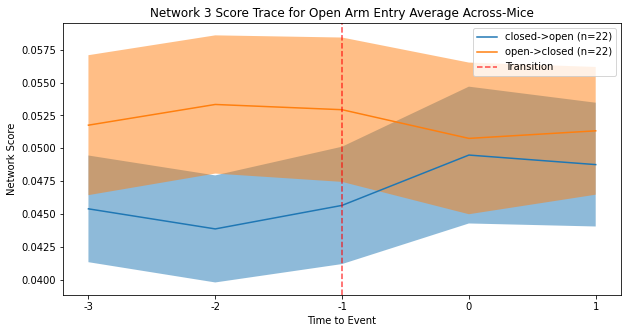

In [3]:
n_windows_before = 3
n_windows_after = 2

c2o_n1_mouse_means = []
c2o_n2_mouse_means = []
c2o_n3_mouse_means = []
c2o_mouse_id = []
c2o_event_times = []
c2o_n_segs = []

o2c_n1_mouse_means = []
o2c_n2_mouse_means = []
o2c_n3_mouse_means = []
o2c_mouse_id = []
o2c_event_times = []
o2c_n_segs = []

for mouse in np.unique(df_in_task.mouse):
    print(mouse)
    mouse_mask = df_in_task.mouse==mouse
    nan_filter = df_in_task.roi > 0
    mask = np.logical_and(mouse_mask,nan_filter)
    
    mouse_roi = 1-df_in_task[mask==1]["roi"].values%2
    #mouse_roi = np.logical_or(df_in_task[mask==1]["roi"].values==2,
    #                        df_in_task[mask==1]["roi"].values==4)
    mouse_time = df_in_task[mask==1]["time"].values

    n1_s = df_in_task[mask==1]["net 1 scores"].values
    n2_s = df_in_task[mask==1]["net 2 scores"].values
    n3_s = df_in_task[mask==1]["net 3 scores"].values
    
    c2o_seg_idxs = []
    o2c_seg_idxs = []

    for idx, roi in enumerate(mouse_roi):
        
        
        if idx > n_windows_before and idx < (len(mouse_roi) - n_windows_after):
            
            #Get CA to OA
            seg_start = idx - n_windows_before
            seg_end = idx + n_windows_after
            
            c2o_isTransition = mouse_roi[idx]==1 and mouse_roi[idx-1]==0

            c2o_beforeStable = np.sum(mouse_roi[seg_start:idx])==0
            c2o_afterStable = np.sum(mouse_roi[idx:seg_end])==n_windows_after
            c2o_isStable = np.logical_and(c2o_beforeStable,c2o_afterStable)
            c2o_isCont = np.array_equal(mouse_time[seg_start:seg_end], np.arange(mouse_time[seg_start],mouse_time[seg_end]))
            
            if c2o_isTransition and c2o_isStable and c2o_isCont:
                c2o_seg_idxs.append((seg_start,seg_end))
                
            #Get OA to CA
            o2c_isTransition = mouse_roi[idx]==0 and mouse_roi[idx-1]==1

            o2c_beforeStable = np.sum(mouse_roi[seg_start:idx])==n_windows_before
            o2c_afterStable = np.sum(mouse_roi[idx:seg_end])==0
            o2c_isStable = np.logical_and(o2c_beforeStable,o2c_afterStable)
            o2c_isCont = np.array_equal(mouse_time[seg_start:seg_end], np.arange(mouse_time[seg_start],mouse_time[seg_end]))
            if o2c_isTransition and o2c_isStable and o2c_isCont:
                o2c_seg_idxs.append((seg_start,seg_end))
              
    #save ca to oa segments
    if len(c2o_seg_idxs) > 0:
        c2o_n1_segs_mean = np.mean(np.array([n1_s[start:end] for start, end in c2o_seg_idxs]),
                          axis=0)
        c2o_n2_segs_mean = np.mean(np.array([n2_s[start:end] for start, end in c2o_seg_idxs]),
                          axis=0)
        c2o_n3_segs_mean = np.mean(np.array([n3_s[start:end] for start, end in c2o_seg_idxs]),
                          axis=0)

        c2o_n1_mouse_means.append(c2o_n1_segs_mean)
        c2o_n2_mouse_means.append(c2o_n2_segs_mean)
        c2o_n3_mouse_means.append(c2o_n3_segs_mean)
        c2o_mouse_id.append(mouse)
        c2o_event_times.append([mouse_time[start_seg] for start_seg, end_seg in c2o_seg_idxs])
        c2o_n_segs.append(len(c2o_seg_idxs))
      
    #save oa to ca segments
    if len(o2c_seg_idxs) > 0:
        o2c_n1_segs_mean = np.mean(np.array([n1_s[start:end] for start, end in o2c_seg_idxs]),
                          axis=0)
        o2c_n2_segs_mean = np.mean(np.array([n2_s[start:end] for start, end in o2c_seg_idxs]),
                          axis=0)
        o2c_n3_segs_mean = np.mean(np.array([n3_s[start:end] for start, end in o2c_seg_idxs]),
                          axis=0)

        o2c_n1_mouse_means.append(o2c_n1_segs_mean)
        o2c_n2_mouse_means.append(o2c_n2_segs_mean)
        o2c_n3_mouse_means.append(o2c_n3_segs_mean)
        o2c_event_times.append([mouse_time[start_seg] for start_seg, end_seg in o2c_seg_idxs])
        o2c_mouse_id.append(mouse)
        o2c_n_segs.append(len(o2c_seg_idxs))
    
c2o_n1_mouse_means = np.array(c2o_n1_mouse_means)
c2o_n2_mouse_means = np.array(c2o_n2_mouse_means)
c2o_n3_mouse_means = np.array(c2o_n3_mouse_means)
c2o_event_times = np.array(c2o_event_times,dtype=object)
c2o_mouse_id = np.array(c2o_mouse_id)
c2o_n_segs = np.array(c2o_n_segs)

o2c_n1_mouse_means = np.array(o2c_n1_mouse_means)
o2c_n2_mouse_means = np.array(o2c_n2_mouse_means)
o2c_n3_mouse_means = np.array(o2c_n3_mouse_means)
o2c_event_times = np.array(o2c_event_times,dtype=object)
o2c_mouse_id = np.array(o2c_mouse_id)
o2c_n_segs = np.array(o2c_n_segs)

c2o_scores_list = [c2o_n1_mouse_means, c2o_n2_mouse_means, c2o_n3_mouse_means]
o2c_scores_list = [o2c_n1_mouse_means, o2c_n2_mouse_means, o2c_n3_mouse_means]
print(c2o_mouse_id,c2o_event_times,"\n\n",o2c_mouse_id,o2c_event_times)
for net in range(3):
    
    mean = np.mean(c2o_scores_list[net],axis=0)
    stderr = np.std(c2o_scores_list[net],axis=0) / np.sqrt(c2o_scores_list[net].shape[0])
    
    plt.figure(figsize=(10,5))
    plt.plot(mean, label="closed->open (n={})".format(len(c2o_mouse_id)))
    
    plt.fill_between(range(n_windows_before + n_windows_after),
                     mean+stderr,mean-stderr,alpha=0.5)
    
    mean = np.mean(o2c_scores_list[net],axis=0)
    stderr = np.std(o2c_scores_list[net],axis=0) / np.sqrt(o2c_scores_list[net].shape[0])
    
    plt.plot(mean, label="open->closed (n={})".format(len(o2c_mouse_id)))
    #plt.axvline(x=n_windows_before-1,color="red",linestyle="dashed",alpha=0.7,label="Open Arm Entry")
    
    plt.fill_between(range(n_windows_before + n_windows_after),
                     mean+stderr,mean-stderr,alpha=0.5)
    
    plt.axvline(x=n_windows_before-1,color="red",linestyle="dashed",alpha=0.7,label="Transition")
    plt.ylabel("Network Score")
    plt.xlabel("Time to Event")
    plt.xticks(range(n_windows_before + n_windows_after), 
               np.arange(n_windows_before + n_windows_after) - n_windows_before)
    #plt.ylim([3.2,5.5])
    plt.legend()
    plt.title("Network {} Score Trace for Open Arm Entry Average Across-Mice".format(net+1))
    plt.show()
    
    c2o_saveMat = np.hstack([c2o_mouse_id.reshape(-1,1),
                            np.array(["closed->open" for _ in c2o_mouse_id]).reshape(-1,1),
                             np.array(c2o_scores_list[net])]).astype(object)
    c2cl_saveMat = np.hstack([o2c_mouse_id.reshape(-1,1),
                            np.array(["open->closed" for _ in o2c_mouse_id]).reshape(-1,1),
                           np.array(o2c_scores_list[net])]).astype(object)
    
    saveMat = np.vstack([c2o_saveMat,c2cl_saveMat])
    temp_df = pd.DataFrame(saveMat,columns=["mouse","decision","-3","-2","-1","0","1"])
    #temp_df.to_csv(PROJECT_PATH + "EPM_closed_to_open_vs_open_to_closed_net_{}.csv".format(net))

In [183]:
print(c2o_mouse_id)
      
print(c2o_event_times)

['Mouse0641' 'Mouse39115' 'Mouse39121' 'Mouse39122' 'Mouse39132'
 'Mouse39135' 'Mouse6674' 'Mouse69061' 'Mouse69071' 'Mouse69075'
 'Mouse8893']
[list([439]) list([411, 444, 504, 584]) list([369, 435, 526, 657])
 list([325, 332, 359, 386, 440, 515, 578, 642]) list([331, 372, 394, 512])
 list([360, 398, 474, 592, 653, 662])
 list([148, 167, 238, 318, 450, 478, 545, 591, 657])
 list([340, 384, 426, 459, 532]) list([495, 597, 672])
 list([357, 408, 423, 440, 614]) list([567, 599, 694])]


In [189]:
print(c2o_mouse_id)
print(c2o_time_ids)

['Mouse39115' 'Mouse39121' 'Mouse39122' 'Mouse39132' 'Mouse39135'
 'Mouse69061' 'Mouse69071' 'Mouse8893']
[list([444, 584]) list([369, 435]) list([325, 332, 359, 386, 440, 515])
 list([372]) list([398, 474, 592, 662]) list([340]) list([495, 597, 672])
 list([694])]


In [188]:
event=584
time_mask = np.logical_and(df_in_task.time>=event,df_in_task.time<event+n_windows_before+n_windows_after)
df_in_task[np.logical_and(df_in_task.mouse=="Mouse39115",time_mask==1)]

,Unnamed: 0,net 1 scores,net 2 scores,net 3 scores,in-task,mouse,time,expDate,auc (Homecage vs. Task),net 1 auc (Homecage vs. Task),net 2 auc (Homecage vs. Task),net 3 auc (Homecage vs. Task),roi,velocity
892,892,0.097401,0.236530,0.080425,True,Mouse39115,584,91921,0.891686,0.920338,0.853986,0.579652,5,3
893,893,0.089687,0.078743,0.057505,True,Mouse39115,585,91921,0.891686,0.920338,0.853986,0.579652,5,1
894,894,0.068511,0.123802,0.049330,True,Mouse39115,586,91921,0.891686,0.920338,0.853986,0.579652,5,0
895,895,0.086597,0.124635,0.063293,True,Mouse39115,587,91921,0.891686,0.920338,0.853986,0.579652,2,1
896,896,0.084997,0.178723,0.061585,True,Mouse39115,588,91921,0.891686,0.920338,0.853986,0.579652,2,2


Mouse04193 353 953
Mouse04201 343 943
Mouse04202 348 948
Mouse04205 321 921
Mouse04215 327 927
Mouse0630 162 762
Mouse0633 139 739
Mouse0634 137 737
Mouse0642 144 744
Mouse0643 164 764
Mouse1551 148 748
Mouse39114 341 941
Mouse39124 328 928
Mouse39125 319 919
Mouse39133 420 1020
Mouse6291 209 809
Mouse6292 220 820
Mouse6293 214 814
Mouse69064 325 925
Mouse69065 366 966
Mouse69074 326 926
Mouse8580 180 780
Mouse8581 147 747
Mouse8582 159 759
Mouse8891 149 749
Mouse8894 143 743
['Mouse04193' 'Mouse04201' 'Mouse04202' 'Mouse04215' 'Mouse0630'
 'Mouse0633' 'Mouse0634' 'Mouse0642' 'Mouse0643' 'Mouse1551' 'Mouse39124'
 'Mouse39125' 'Mouse39133' 'Mouse6291' 'Mouse6292' 'Mouse6293'
 'Mouse69064' 'Mouse69065' 'Mouse69074' 'Mouse8580' 'Mouse8581'
 'Mouse8891'] [list([397, 411, 479, 535, 644]) list([357, 366, 460, 526, 595, 647])
 list([369, 455, 575]) list([345])
 list([178, 198, 233, 374, 480, 513, 589, 650, 714])
 list([159, 174, 199, 234, 252, 274, 317, 610, 628, 685])
 list([297, 377, 408]) 

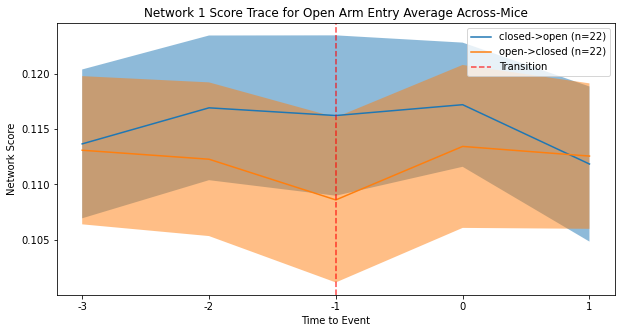

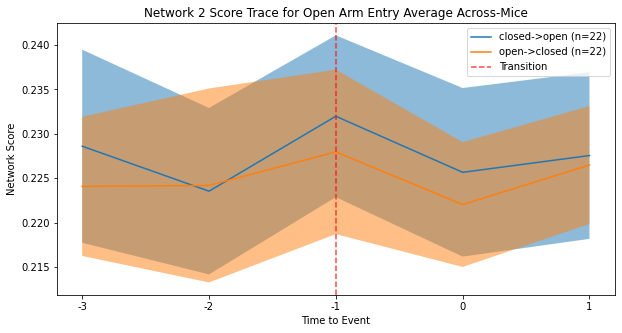

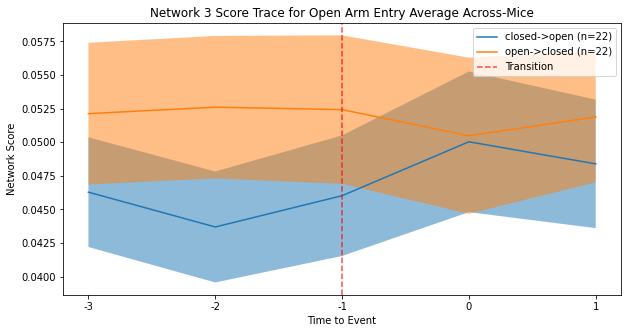

In [4]:
n_windows_before = 3
n_windows_after = 2

c2o_n1_mouse_means = []
c2o_n2_mouse_means = []
c2o_n3_mouse_means = []
c2o_mouse_id = []
c2o_event_times = []
c2o_n_segs = []

o2c_n1_mouse_means = []
o2c_n2_mouse_means = []
o2c_n3_mouse_means = []
o2c_mouse_id = []
o2c_event_times = []
o2c_n_segs = []

for mouse in np.unique(df_in_task.mouse):
    #print(mouse)
    mouse_mask = df_in_task.mouse==mouse
    
    nan_filter = df_in_task.roi > 0
    mask = np.logical_and(mouse_mask,nan_filter)
    
    mouse_time = df_in_task[mask==1]["time"].values
    task_start_time = np.min(mouse_time)
    task_end_time = task_start_time + 600
    time_mask = df_in_task.time < task_end_time
    print(mouse,task_start_time,task_end_time)
    mask = np.logical_and(mask,time_mask)
    n1_s = df_in_task[mask==1]["net 1 scores"].values
    n2_s = df_in_task[mask==1]["net 2 scores"].values
    n3_s = df_in_task[mask==1]["net 3 scores"].values
    
    mouse_roi = 1-df_in_task[mask==1]["roi"].values%2
    #mouse_roi = np.logical_or(df_in_task[mask==1]["roi"].values==2,
    #                        df_in_task[mask==1]["roi"].values==4)
    
    c2o_seg_idxs = []
    o2c_seg_idxs = []

    for idx, roi in enumerate(mouse_roi):
        
        
        if idx > n_windows_before and idx < (len(mouse_roi) - n_windows_after):
            
            #Get CA to OA
            seg_start = idx - n_windows_before
            seg_end = idx + n_windows_after
            
            c2o_isTransition = mouse_roi[idx]==1 and mouse_roi[idx-1]==0

            c2o_beforeStable = np.sum(mouse_roi[seg_start:idx])==0
            c2o_afterStable = np.sum(mouse_roi[idx:seg_end])==n_windows_after
            c2o_isStable = np.logical_and(c2o_beforeStable,c2o_afterStable)
            c2o_isCont = np.array_equal(mouse_time[seg_start:seg_end], np.arange(mouse_time[seg_start],mouse_time[seg_end]))
            
            if c2o_isTransition and c2o_isStable and c2o_isCont:
                c2o_seg_idxs.append((seg_start,seg_end))
                
            #Get OA to CA
            o2c_isTransition = mouse_roi[idx]==0 and mouse_roi[idx-1]==1

            o2c_beforeStable = np.sum(mouse_roi[seg_start:idx])==n_windows_before
            o2c_afterStable = np.sum(mouse_roi[idx:seg_end])==0
            o2c_isStable = np.logical_and(o2c_beforeStable,o2c_afterStable)
            o2c_isCont = np.array_equal(mouse_time[seg_start:seg_end], np.arange(mouse_time[seg_start],mouse_time[seg_end]))
            if o2c_isTransition and o2c_isStable and o2c_isCont:
                o2c_seg_idxs.append((seg_start,seg_end))
              
    #save ca to oa segments
    if len(c2o_seg_idxs) > 0:
        c2o_n1_segs_mean = np.mean(np.array([n1_s[start:end] for start, end in c2o_seg_idxs]),
                          axis=0)
        c2o_n2_segs_mean = np.mean(np.array([n2_s[start:end] for start, end in c2o_seg_idxs]),
                          axis=0)
        c2o_n3_segs_mean = np.mean(np.array([n3_s[start:end] for start, end in c2o_seg_idxs]),
                          axis=0)

        c2o_n1_mouse_means.append(c2o_n1_segs_mean)
        c2o_n2_mouse_means.append(c2o_n2_segs_mean)
        c2o_n3_mouse_means.append(c2o_n3_segs_mean)
        c2o_mouse_id.append(mouse)
        c2o_event_times.append([mouse_time[start_seg] for start_seg, end_seg in c2o_seg_idxs])
        c2o_n_segs.append(len(c2o_seg_idxs))
      
    #save oa to ca segments
    if len(o2c_seg_idxs) > 0:
        o2c_n1_segs_mean = np.mean(np.array([n1_s[start:end] for start, end in o2c_seg_idxs]),
                          axis=0)
        o2c_n2_segs_mean = np.mean(np.array([n2_s[start:end] for start, end in o2c_seg_idxs]),
                          axis=0)
        o2c_n3_segs_mean = np.mean(np.array([n3_s[start:end] for start, end in o2c_seg_idxs]),
                          axis=0)

        o2c_n1_mouse_means.append(o2c_n1_segs_mean)
        o2c_n2_mouse_means.append(o2c_n2_segs_mean)
        o2c_n3_mouse_means.append(o2c_n3_segs_mean)
        o2c_event_times.append([mouse_time[start_seg] for start_seg, end_seg in o2c_seg_idxs])
        o2c_mouse_id.append(mouse)
        o2c_n_segs.append(len(o2c_seg_idxs))
    
c2o_n1_mouse_means = np.array(c2o_n1_mouse_means)
c2o_n2_mouse_means = np.array(c2o_n2_mouse_means)
c2o_n3_mouse_means = np.array(c2o_n3_mouse_means)
c2o_event_times = np.array(c2o_event_times,dtype=object)
c2o_mouse_id = np.array(c2o_mouse_id)
c2o_n_segs = np.array(c2o_n_segs)

o2c_n1_mouse_means = np.array(o2c_n1_mouse_means)
o2c_n2_mouse_means = np.array(o2c_n2_mouse_means)
o2c_n3_mouse_means = np.array(o2c_n3_mouse_means)
o2c_event_times = np.array(o2c_event_times,dtype=object)
o2c_mouse_id = np.array(o2c_mouse_id)
o2c_n_segs = np.array(o2c_n_segs)

c2o_scores_list = [c2o_n1_mouse_means, c2o_n2_mouse_means, c2o_n3_mouse_means]
o2c_scores_list = [o2c_n1_mouse_means, o2c_n2_mouse_means, o2c_n3_mouse_means]
print(c2o_mouse_id,c2o_event_times,"\n\n",o2c_mouse_id,o2c_event_times)
for net in range(3):
    
    mean = np.mean(c2o_scores_list[net],axis=0)
    stderr = np.std(c2o_scores_list[net],axis=0) / np.sqrt(c2o_scores_list[net].shape[0])
    
    plt.figure(figsize=(10,5))
    plt.plot(mean, label="closed->open (n={})".format(len(c2o_mouse_id)))
    
    plt.fill_between(range(n_windows_before + n_windows_after),
                     mean+stderr,mean-stderr,alpha=0.5)
    
    mean = np.mean(o2c_scores_list[net],axis=0)
    stderr = np.std(o2c_scores_list[net],axis=0) / np.sqrt(o2c_scores_list[net].shape[0])
    
    plt.plot(mean, label="open->closed (n={})".format(len(o2c_mouse_id)))
    #plt.axvline(x=n_windows_before-1,color="red",linestyle="dashed",alpha=0.7,label="Open Arm Entry")
    
    plt.fill_between(range(n_windows_before + n_windows_after),
                     mean+stderr,mean-stderr,alpha=0.5)
    
    plt.axvline(x=n_windows_before-1,color="red",linestyle="dashed",alpha=0.7,label="Transition")
    plt.ylabel("Network Score")
    plt.xlabel("Time to Event")
    plt.xticks(range(n_windows_before + n_windows_after), 
               np.arange(n_windows_before + n_windows_after) - n_windows_before)
    #plt.ylim([3.2,5.5])
    plt.legend()
    plt.title("Network {} Score Trace for Open Arm Entry Average Across-Mice".format(net+1))
    plt.show()

### Center -> Open vs. Center -> Closed

In [10]:
# Define window sizes before and after a specific point
n_windows_before = 2
n_windows_after = 1

# Initialize lists to store means and other data for different conditions and mice
c2o_n1_mouse_means = []
c2o_n2_mouse_means = []
c2o_n3_mouse_means = []
c2o_time_ids = []
c2o_mouse_id = []
c2o_n_segs = []

c2cl_n1_mouse_means = []
c2cl_n2_mouse_means = []
c2cl_n3_mouse_means = []
c2cl_time_ids = []
c2cl_mouse_id = []
c2cl_n_segs = []

# Iterate over unique mice in the dataframe
for mouse in np.unique(df_in_task.mouse):

    # Create a mask for the current mouse
    mouse_mask = df_in_task.mouse==mouse
    # Filter out NaN values in the ROI column
    nan_filter = np.logical_and(df_in_task.roi > 0, 1-np.isnan(df_in_task.roi))
    mask = np.logical_and(mouse_mask,nan_filter)
    
    mouse_time = df_in_task[mask==1]["time"].values
    task_start_time = np.min(mouse_time)
    task_end_time = task_start_time + 300
    time_mask = df_in_task.time < task_end_time
    print(mouse,task_start_time,task_end_time)
    mask = np.logical_and(mask,time_mask)
    
    # Define masks for different conditions (CA, OA)
    oa_mask = np.logical_or(df_in_task[mask==1]["roi"].values==2,
                            df_in_task[mask==1]["roi"].values==4)

    ca_mask = np.logical_or(df_in_task[mask==1]["roi"].values==1,
                            df_in_task[mask==1]["roi"].values==3)
    
    # Extract relevant data for the current mouse and condition
    mouse_roi = df_in_task[mask==1]["roi"].values
    mouse_time = df_in_task[mask==1]["time"].values
    n1_s = df_in_task[mask==1]["net 1 scores"].values
    n2_s = df_in_task[mask==1]["net 2 scores"].values
    n3_s = df_in_task[mask==1]["net 3 scores"].values
    
    # Initialize lists to store segment indexes for different conditions
    c2o_seg_idxs = []
    c2cl_seg_idxs = []

    # Iterate over ROI indexes and values
    for idx, roi in enumerate(mouse_roi):
        
        # Check if the current index is within the valid range
        if idx > n_windows_before and idx < (len(mouse_roi) - n_windows_after):
            
            # Get segment start and end points for CA to OA transition
            seg_start = idx - n_windows_before
            seg_end = idx + n_windows_after
            
            # Check for CA to OA transition conditions
            c2o_isTransition = oa_mask[idx]==1 and mouse_roi[idx-1]==5 and oa_mask[idx-2] == 0
            
            c2o_beforeStable = np.sum(oa_mask[seg_start:idx])==0
            c2o_afterStable = np.sum(oa_mask[idx:seg_end])==n_windows_after
            c2o_isStable = np.logical_and(c2o_beforeStable,c2o_afterStable)
            
            c2o_isCont = np.array_equal(mouse_time[seg_start:seg_end], np.arange(mouse_time[seg_start],mouse_time[seg_end]))
            
            if c2o_isTransition and c2o_isStable and c2o_isCont:
                c2o_seg_idxs.append((seg_start,seg_end))
                
            # Get segment start and end points for OA to CA transition
            c2cl_isTransition = mouse_roi[idx-1]==5 and oa_mask[idx-2]==0 and ca_mask[idx] == 1
            c2cl_beforeStable = np.sum(oa_mask[seg_start:idx])==0
            c2cl_afterStable = np.sum(ca_mask[idx:seg_end])==n_windows_after
            c2cl_isStable = np.logical_and(c2cl_beforeStable,c2cl_afterStable)
            c2cl_isCont = np.array_equal(mouse_time[seg_start:seg_end], np.arange(mouse_time[seg_start],mouse_time[seg_end]))

            if c2cl_isTransition and c2cl_isStable:
                c2cl_seg_idxs.append((seg_start,seg_end))
              
    # Save CA to OA segments if found
    if len(c2o_seg_idxs) > 0:
        # Calculate mean values for net scores within segments
        c2o_n1_segs_mean = np.mean(np.array([n1_s[start:end] for start, end in c2o_seg_idxs]), axis=0)
        c2o_n2_segs_mean = np.mean(np.array([n2_s[start:end] for start, end in c2o_seg_idxs]), axis=0)
        c2o_n3_segs_mean = np.mean(np.array([n3_s[start:end] for start, end in c2o_seg_idxs]), axis=0)

        # Append means and other data to respective lists
        c2o_n1_mouse_means.append(c2o_n1_segs_mean)
        c2o_n2_mouse_means.append(c2o_n2_segs_mean)
        c2o_n3_mouse_means.append(c2o_n3_segs_mean)
        c2o_time_ids.append([mouse_time[start_seg] for start_seg, end_seg in c2o_seg_idxs])
        c2o_mouse_id.append(mouse)
        c2o_n_segs.append(len(c2o_seg_idxs))
      
    # Save OA to CA segments if found
    if len(c2cl_seg_idxs) > 0:
        # Calculate mean values for net scores within segments
        c2cl_n1_segs_mean = np.mean(np.array([n1_s[start:end] for start, end in c2cl_seg_idxs]), axis=0)
        c2cl_n2_segs_mean = np.mean(np.array([n2_s[start:end] for start, end in c2cl_seg_idxs]), axis=0)
        c2cl_n3_segs_mean = np.mean(np.array([n3_s[start:end] for start, end in c2cl_seg_idxs]), axis=0)

        # Append means and other data to respective lists
        c2cl_n1_mouse_means.append(c2cl_n1_segs_mean)
        c2cl_n2_mouse_means.append(c2cl_n2_segs_mean)
        c2cl_n3_mouse_means.append(c2cl_n3_segs_mean)
        c2cl_time_ids.append([mouse_time[start_seg] for start_seg, end_seg in c2cl_seg_idxs])
        c2cl_mouse_id.append(mouse)
        c2cl_n_segs.append(len(c2cl_seg_idxs))
    
# Convert lists to numpy arrays for easier manipulation
c2o_n1_mouse_means = np.array(c2o_n1_mouse_means)
c2o_n2_mouse_means = np.array(c2o_n2_mouse_means)
c2o_n3_mouse_means = np.array(c2o_n3_mouse_means)
c2o_mouse_id = np.array(c2o_mouse_id)
c2o_time_ids = np.array(c2o_time_ids,dtype=object)
c2o_n_segs = np.array(c2o_n_segs)

c2cl_n1_mouse_means = np.array(c2cl_n1_mouse_means)
c2cl_n2_mouse_means = np.array(c2cl_n2_mouse_means)
c2cl_n3_mouse_means = np.array(c2cl_n3_mouse_means)
c2cl_mouse_id = np.array(c2cl_mouse_id)
c2cl_time_ids = np.array(c2cl_time_ids,dtype=object)
c2cl_n_segs = np.array(c2cl_n_segs)

# Organize scores lists for CA to OA and OA to CA transitions
c2o_scores_list = [c2o_n1_mouse_means, c2o_n2_mouse_means, c2o_n3_mouse_means]
c2cl_scores_list = [c2cl_n1_mouse_means, c2cl_n2_mouse_means, c2cl_n3_mouse_means]



Mouse04193 353 653
Mouse04201 343 643
Mouse04202 348 648
Mouse04205 321 621
Mouse04215 327 627
Mouse0630 162 462
Mouse0633 139 439
Mouse0634 137 437
Mouse0642 144 444
Mouse0643 164 464
Mouse1551 148 448
Mouse39114 341 641
Mouse39124 328 628
Mouse39125 319 619
Mouse39133 420 720
Mouse6291 209 509
Mouse6292 220 520
Mouse6293 214 514
Mouse69064 325 625
Mouse69065 366 666
Mouse69074 326 626
Mouse8580 180 480
Mouse8581 147 447
Mouse8582 159 459
Mouse8891 149 449
Mouse8894 143 443


In [26]:
print("three seconds before")
print("Center -> Open")
for mouse,nsegs in zip(c2o_mouse_id,c2o_n_segs):
    print(mouse,nsegs)
    
print("\nCenter -> Closed")

for mouse,nsegs in zip(c2cl_mouse_id,c2cl_n_segs):
    print(mouse,nsegs)

three seconds before
Center -> Open
Mouse39115 2
Mouse39121 2
Mouse39122 6
Mouse39132 1
Mouse39135 3
Mouse69061 1
Mouse69071 2

Center -> Closed
Mouse0641 5
Mouse39115 3
Mouse39121 3
Mouse39122 5
Mouse39132 4
Mouse39135 6
Mouse69061 10
Mouse69075 1
Mouse8893 5


In [31]:
print("two seconds before")
print("Center -> Open")
for mouse,nsegs in zip(c2o_mouse_id,c2o_n_segs):
    print(mouse,nsegs)
    
print("\nCenter -> Closed")

for mouse,nsegs in zip(c2cl_mouse_id,c2cl_n_segs):
    print(mouse,nsegs)

two seconds before
Center -> Open
Mouse39115 2
Mouse39121 2
Mouse39122 7
Mouse39132 1
Mouse39135 3
Mouse6674 1
Mouse69061 1
Mouse69071 2

Center -> Closed
Mouse0641 5
Mouse39115 3
Mouse39121 4
Mouse39122 7
Mouse39132 5
Mouse39135 7
Mouse69061 10
Mouse69075 2
Mouse8893 6


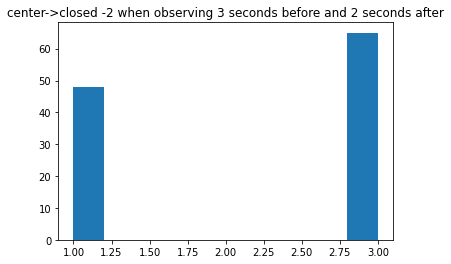

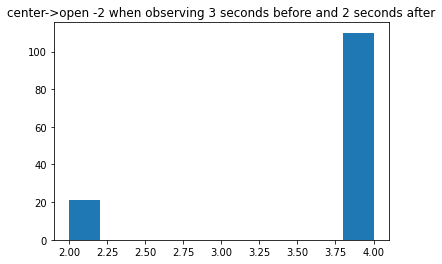

In [8]:
before_center_loc = []
for start_list,mouse in zip(c2cl_time_ids,c2cl_mouse_id):
    mouse_mask = df_in_task.mouse==mouse
    for start in start_list:
        
        time_mask = df_in_task.time==(start+1)
        slice_mask = np.logical_and(mouse_mask,time_mask)
        if np.sum(slice_mask) > 0:
            before_center_loc.append(df_in_task[np.logical_and(mouse_mask,time_mask)]["roi"].values[0])
        
plt.hist(np.array(before_center_loc).squeeze())
plt.title("center->closed -2 when observing 3 seconds before and 2 seconds after")
plt.show()

before_center_loc = []
for start_list,mouse in zip(c2o_time_ids,c2o_mouse_id):
    mouse_mask = df_in_task.mouse==mouse
    for start in start_list:
        
        time_mask = df_in_task.time==(start+1)
        slice_mask = np.logical_and(mouse_mask,time_mask)
        if np.sum(slice_mask) > 0:
            before_center_loc.append(df_in_task[np.logical_and(mouse_mask,time_mask)]["roi"].values[0])
        
plt.hist(np.array(before_center_loc).squeeze())
plt.title("center->open -2 when observing 3 seconds before and 2 seconds after")
plt.show()

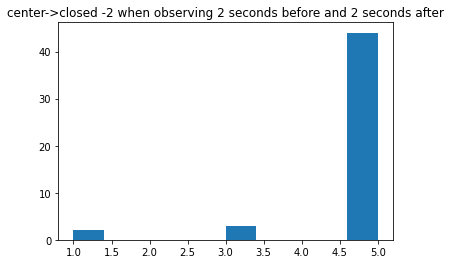

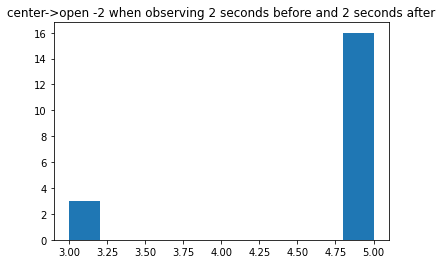

In [30]:
before_center_loc = []
for start_list,mouse in zip(c2cl_time_ids,c2cl_mouse_id):
    mouse_mask = df_in_task.mouse==mouse
    for start in start_list:
        
        time_mask = df_in_task.time==(start)
        slice_mask = np.logical_and(mouse_mask,time_mask)
        if np.sum(slice_mask) > 0:
            before_center_loc.append(df_in_task[np.logical_and(mouse_mask,time_mask)]["roi"].values[0])
        
plt.hist(np.array(before_center_loc).squeeze())
plt.title("center->closed -2 when observing 2 seconds before and 2 seconds after")
plt.show()

before_center_loc = []
for start_list,mouse in zip(c2o_time_ids,c2o_mouse_id):
    mouse_mask = df_in_task.mouse==mouse
    for start in start_list:
        
        time_mask = df_in_task.time==(start)
        slice_mask = np.logical_and(mouse_mask,time_mask)
        if np.sum(slice_mask) > 0:
            before_center_loc.append(df_in_task[np.logical_and(mouse_mask,time_mask)]["roi"].values[0])
        
plt.hist(np.array(before_center_loc).squeeze())
plt.title("center->open -2 when observing 2 seconds before and 2 seconds after")
plt.show()

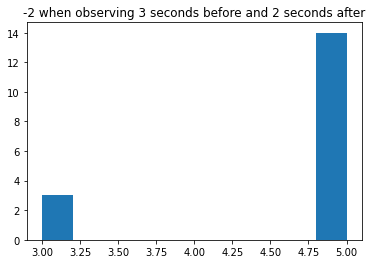

In [54]:
plt.hist(np.array(before_center_loc).squeeze())
plt.title("-2 when observing 3 seconds before and 2 seconds after")
plt.show()

In [53]:
before_center_loc = []
for start_list,mouse in zip(c2o_time_ids,c2o_mouse_id):
    mouse_mask = df_in_task.mouse==mouse
    for start in start_list:
        time_mask = df_in_task.time==(start+1)
        before_center_loc.append(df_in_task[np.logical_and(mouse_mask,time_mask)]["roi"].values)

In [35]:
print(mouse_time[seg_start:seg_end], np.arange(mouse_time[seg_start],mouse_time[seg_end]))

[432 433 434 435] [432 433 434 435]


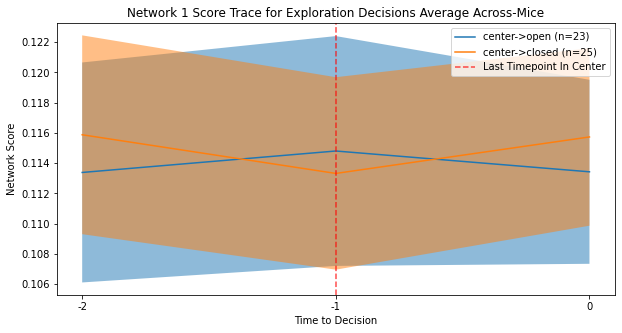

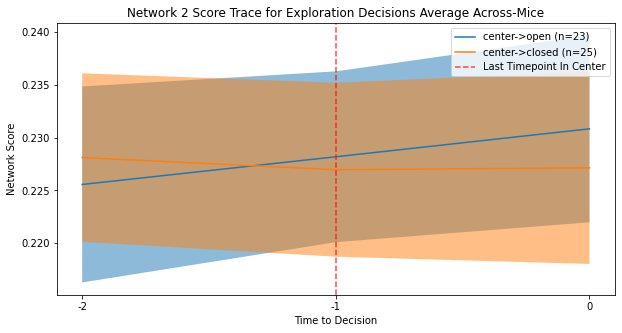

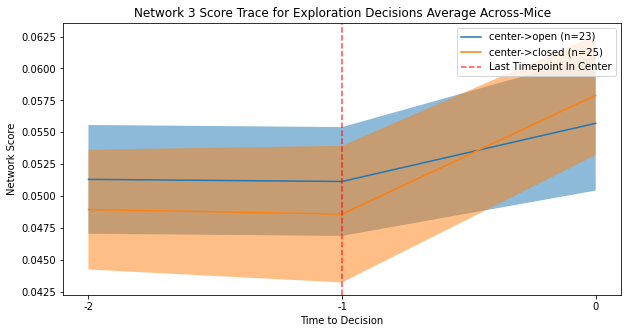

In [12]:
for net in range(3):
    
    mean = np.mean(c2o_scores_list[net],axis=0)
    stderr = np.std(c2o_scores_list[net],axis=0) / np.sqrt(c2o_scores_list[net].shape[0])
    
    plt.figure(figsize=(10,5))
    plt.plot(mean, label="center->open (n={})".format(len(c2o_mouse_id)))
    
    plt.fill_between(range(n_windows_before + n_windows_after),
                     mean+stderr,mean-stderr,alpha=0.5)
    
    mean = np.mean(c2cl_scores_list[net],axis=0)
    stderr = np.std(c2cl_scores_list[net],axis=0) / np.sqrt(c2cl_scores_list[net].shape[0])
    
    plt.plot(mean, label="center->closed (n={})".format(len(c2cl_mouse_id)))
    
    plt.fill_between(range(n_windows_before + n_windows_after),
                     mean+stderr,mean-stderr,alpha=0.5)
    
    plt.axvline(x=n_windows_before-1,color="red",linestyle="dashed",alpha=0.7,label="Last Timepoint In Center")
    plt.ylabel("Network Score")
    plt.xlabel("Time to Decision")
    plt.xticks(range(n_windows_before + n_windows_after), 
               np.arange(n_windows_before + n_windows_after) - n_windows_before)

    plt.legend()
    plt.title("Network {} Score Trace for Exploration Decisions Average Across-Mice".format(net+1))
    plt.show()
    
    c2o_saveMat = np.hstack([c2o_mouse_id.reshape(-1,1),
                            np.array(["center->open" for _ in c2o_mouse_id]).reshape(-1,1),
                             np.array(c2o_scores_list[net])]).astype(object)
    c2cl_saveMat = np.hstack([c2cl_mouse_id.reshape(-1,1),
                            np.array(["center->closed" for _ in c2cl_mouse_id]).reshape(-1,1),
                           np.array(c2cl_scores_list[net])]).astype(object)
    
    saveMat = np.vstack([c2o_saveMat,c2cl_saveMat])
    temp_df = pd.DataFrame(saveMat,columns=["mouse","decision","-2","-1","0"])
    #temp_df.to_csv(PROJECT_PATH + "two_before_EPM_center_to_open_vs_center_to_closed_net_{}.csv".format(net))

## Collect Mean Scores Prior to First Entry

In [35]:
import numpy as np
n1_pre_means = []
n2_pre_means = []
n3_pre_means = []
pre_mice = []
n_windows_prior = []
for mouse in np.unique(df_in_task.mouse):
    
    # Create a mask for the current mouse
    mouse_mask = df_in_task.mouse==mouse
    # Filter out NaN values in the ROI column
    nan_filter = df_in_task.roi > 0
    mask = np.logical_and(mouse_mask,nan_filter)
    
    mouse_time = df_in_task[mask==1]["time"].values
    task_start_time = np.min(mouse_time)
    task_end_time = task_start_time + 600
    time_mask = df_in_task.time < task_end_time
    #print(mouse,task_start_time,task_end_time)
    mask = np.logical_and(mask,time_mask)
    
    # Extract relevant data for the current mouse and condition
    mouse_roi = df_in_task[mask==1]["roi"].values
    mouse_time = df_in_task[mask==1]["time"].values
    n1_s = df_in_task[mask==1]["net 1 scores"].values
    n2_s = df_in_task[mask==1]["net 2 scores"].values
    n3_s = df_in_task[mask==1]["net 3 scores"].values
    
    # Define masks for different conditions (CA, OA)
    oa_mask = np.logical_or(df_in_task[mask==1]["roi"].values==2,
                            df_in_task[mask==1]["roi"].values==4)

    ca_mask = np.logical_or(df_in_task[mask==1]["roi"].values==1,
                            df_in_task[mask==1]["roi"].values==3)
    
    #Check for that there is a transition
    pre_first_transition_mask = np.cumsum(oa_mask)==0
    
    if np.sum(pre_first_transition_mask) > 0:
        print(mouse,np.sum(pre_first_transition_mask))
        n1_pre_means.append(np.mean(n1_s[pre_first_transition_mask==1]))
        n2_pre_means.append(np.mean(n2_s[pre_first_transition_mask==1]))
        n3_pre_means.append(np.mean(n3_s[pre_first_transition_mask==1]))
        pre_mice.append(mouse)
        n_windows_prior.append(np.sum(pre_first_transition_mask))


Mouse0641 2
Mouse39115 12
Mouse39121 13
Mouse39122 7
Mouse39132 6
Mouse39135 1
Mouse6674 5
Mouse69061 12
Mouse69071 1
Mouse69075 3
Mouse8893 4


In [38]:
df = pd.DataFrame({
    "mouse":pre_mice,
    #"n_windows_prior":n_windows_prior,
    "n1":n1_pre_means,
    "n2":n2_pre_means,
    "n3":n3_pre_means
})

df.to_csv(PROJECT_PATH + "EPM_mean_net_scores_prior_to_first_entry.csv")

In [39]:
df

,mouse,n1,n2,n3
0,Mouse0641,0.135810,0.174058,0.084110
1,Mouse39115,0.100138,0.158368,0.064129
2,Mouse39121,0.121376,0.137868,0.039874
3,Mouse39122,0.064784,0.249580,0.035203
4,Mouse39132,0.065439,0.191763,0.035818
5,Mouse39135,0.067923,0.252376,0.033489
6,Mouse6674,0.078951,0.210790,0.084241
7,Mouse69061,0.106951,0.184481,0.038887
8,Mouse69071,0.080359,0.108348,0.030660
9,Mouse69075,0.085570,0.110198,0.037018
